# Walkthrough guide on multilayer.py
Jack Liu <br>
jyliu2@andrew.cmu.edu <br>
jliu168.7643@gmail.com <br>
July 2022

## I. About

I wrote the `multilayer.py` library in summer 2022 along with David Heson as part of the MTSU-COMS REU, with Dr. William Robertson as our mentor.

It primarily implements the transfer matrix calculation described in Ishida and Ohta [1]. I would definitely recommend cross-referencing with that paper if you want to inspect how the code works; I tried to draw as many variable names and formulas directly from the paper.

## II. Setup

Create a blank Python script or notebook to do your multilayer experiments in. Place `multilayer.py` in the same directory and import it into the file.

You'll almost surely want to also import `numpy` and `matplotlib.pyplot` for your own usage too, though it is not necessary for the library functions to work.

In [1]:
from multilayer import *
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# decreasing print precision to increase readibility throughout notebook
np.set_printoptions(precision=3)

## III. Features for general multilayers

### Reflectivity and transmissivity calculation

Use the `multilayer_RT(theta0, lamb, n, h)` function to calculate the reflectivity `R` and transmissivity `T` of a multilayer given the angle `theta0` (must be in radians) and wavelength `lamb` of an incident wave. `n` and `h` are lists of the refractive indexes and thicknesses, respectively, of each medium in/around the multilayer.

In [3]:
print("defining the multilayer properties")
n = np.array([1.5, 0.08+4.24j, 1.])
h = np.array([50.])
print("n =", n)
print("h =", h)
print()

print("defining the wave properties")
theta0 = 42*np.pi/180 # must be radians
lamb = 650
print("theta0 =", theta0)
print("lamb =", lamb)
print()

print("calculate reflectivity and transmissivity!")
R, T = multilayer_RT(theta0, lamb, n, h)
print("R =", R)
print("T =", T)

defining the multilayer properties
n = [1.5 +0.j   0.08+4.24j 1.  +0.j  ]
h = [50.]

defining the wave properties
theta0 = 0.7330382858376184
lamb = 650

calculate reflectivity and transmissivity!
R = [0.976 0.981]
T = [0. 0.]


The `n` and `h` lists are ordered where their first elements correspond to the "topmost layer" (the layer at which the wave is incident), and you need that `len(h)+2 == len(n)` (since the multilayer is sandwiched by two semi-infinite media).

The output arrays `R` and `T` contain the values for both p- and s-polarizated light. To extract the values for each polarization in seperate variables, you can unpack the arrays like so:

In [4]:
(Rp, Rs) = R
(Tp, Ts) = T
print('Rp =', Rp)
print('Rs =', Rs)
print('Tp =', Tp)
print('Ts =', Ts)

Rp = 0.9757344443726793
Rs = 0.9805154317363817
Tp = 0.0
Ts = 0.0


Above, `theta0` and `lamb` were passed in as scalars, and observe that scalars were returned for the four of `Rp`, `Rs`, `Tp`, and `Ts`. But depending on what you want to calculate, you can pass in `theta0` and `lamb` of varying type and the four outputs will vary accordingly:
- If `theta0` is a *list* and `lamb` is a scalar, you get the outputs in *lists* as a function of the values in `theta0`.
- If `theta0` is a scalar and `lamb` is a *list*, you get the outputs in *lists* as a function of the values in `lamb`.

You can even pass both `theta0` and `lamb` as lists, in which case it will calculate the reflectivity and transmissivity for each point in the Cartesian product of those lists! The four outputs will then be two-dimensional arrays of shape `(len(lamb), len(theta))`.

Here is an example of calculating as a function of $\theta_0$ (notice how the usage is exactly the same as before, only difference being that `theta0` is now a list):

In [5]:
print("defining the multilayer properties")
n = np.array([1.5, 0.08+4.24j, 1.])
h = np.array([50.])
print("n =", n)
print("h =", h)
print()

print("defining the wave properties")
theta0 = np.linspace(start=0.,
                     stop=np.pi/2,
                     num=5,
                     endpoint=False) # a list of five evenly spaced angles
                                     # between 0 and 90 degrees
lamb = 650.
print("theta0 =", theta0)
print("lamb =", lamb)
print()

print("calculate reflectivity and transmissivity!")
R, T = multilayer_RT(theta0, lamb, n, h)
print("R =\n", R)
print("T =\n", T)
print()

(Rp, Rs) = R
(Tp, Ts) = T
print('Rp =', Rp)
print('Rs =', Rs)
print('Tp =', Tp)
print('Ts =', Ts)

defining the multilayer properties
n = [1.5 +0.j   0.08+4.24j 1.  +0.j  ]
h = [50.]

defining the wave properties
theta0 = [0.    0.314 0.628 0.942 1.257]
lamb = 650.0

calculate reflectivity and transmissivity!
R =
 [[0.955 0.951 0.934 0.954 0.954]
 [0.955 0.959 0.972 0.985 0.993]]
T =
 [[0.018 0.021 0.035 0.    0.   ]
 [0.018 0.015 0.007 0.    0.   ]]

Rp = [0.955 0.951 0.934 0.954 0.954]
Rs = [0.955 0.959 0.972 0.985 0.993]
Tp = [0.018 0.021 0.035 0.    0.   ]
Ts = [0.018 0.015 0.007 0.    0.   ]


(Note: if you include $90^\circ$ in your list of angles, you'll get a division by zero warning since $\cos(\frac{\pi}{2})=0$. It won't crash the calculation, but you might get some NaNs in your output.)

#### Calculations with $n$ as function of $\lambda$ (may be bugged?)

In theory, `multilayer_RT` should support having the refractive index of each layer as a function of wavelength. It may be bugged right now though, so use at your own risk. Nonetheless, the intended way to use this functionality is to pass in `lamb` as a list and `n` as a 2D array of shape `(number of media, len(lamb))`. Each entry along axis 0 corresponds to a different medium, and each entry along axis 1 corresponds to a wavelength in the `lamb` list.

Here is an example of a calculation with a multilayer made of $\text{TiO}_2$ and $\text{SiO}_2$ using variable refractive index (take note of the shape of each array):

In [6]:
print("defining refractive indexes and functional dependence if applicable")
# see Koju and Robertson, 2016, Optics Letters
def n_TiO2(lamb):
    return np.sqrt(5.913 + 0.2441/(lamb**2-0.0803)) + 7e-4j
def n_SiO2(lamb):
    return np.sqrt(
        0.6961663*lamb**2/(lamb**2-0.0684043**2)
        + 0.4079462*lamb**2/(lamb**2-0.1162414**2)
        + 0.8974794*lamb**2/(lamb**2-9.896161**2) + 1) + 1e-4j
n_glass = 1.5
n_water = 1.334
print("n_TiO2 =", n_TiO2)
print("n_SiO2 =", n_SiO2)
print("n_glass =", n_glass)
print("n_water =", n_water)
print()

print("defining the wave properties")
theta0 = 70*np.pi/180
lamb = np.linspace(0.43, 0.8, 4) # four evenly spaced wavelengths
                                 # between 0.43 and 0.8 um
print("theta0 =", theta0)
print("lamb =", lamb)
print()

print("let's check how our refractive index functions work:")
print("n_TiO2(lamb) =", n_TiO2(lamb))
print("n_SiO2(lamb) =", n_SiO2(lamb))
print()

print("defining the multilayer properties")
num_bilayers = 3
n = np.array([n_TiO2(lamb) if i%2==1 else n_SiO2(lamb)
              for i in range(2+2*num_bilayers)])
n[0], n[-1] = n_glass, n_water # three bilayers of TiO2/SiO2
h = np.array([0.121 if i%2==0 else 0.188 for i in range(2*num_bilayers)])
h[-1] = 0.410
print("n =\n", n)
print("h =", h)
print()

print("calculate reflectivity and transmissivity!")
(Rp, Rs), (Tp, Ts) = multilayer_RT(theta0, lamb, n, h)
print("Rp =", Rp)
print("Rs =", Rs)
print("Tp =", Tp)
print("Ts =", Ts)

defining refractive indexes and functional dependence if applicable
n_TiO2 = <function n_TiO2 at 0x7faaca6bfe50>
n_SiO2 = <function n_SiO2 at 0x7faaca6bfaf0>
n_glass = 1.5
n_water = 1.334

defining the wave properties
theta0 = 1.2217304763960306
lamb = [0.43  0.553 0.677 0.8  ]

let's check how our refractive index functions work:
n_TiO2(lamb) = [2.872+0.001j 2.645+0.001j 2.561+0.001j 2.52 +0.001j]
n_SiO2(lamb) = [1.467+0.j 1.46 +0.j 1.456+0.j 1.453+0.j]

defining the multilayer properties
n =
 [[1.5  +0.j    1.5  +0.j    1.5  +0.j    1.5  +0.j   ]
 [2.872+0.001j 2.645+0.001j 2.561+0.001j 2.52 +0.001j]
 [1.467+0.j    1.46 +0.j    1.456+0.j    1.453+0.j   ]
 [2.872+0.001j 2.645+0.001j 2.561+0.001j 2.52 +0.001j]
 [1.467+0.j    1.46 +0.j    1.456+0.j    1.453+0.j   ]
 [2.872+0.001j 2.645+0.001j 2.561+0.001j 2.52 +0.001j]
 [1.467+0.j    1.46 +0.j    1.456+0.j    1.453+0.j   ]
 [1.334+0.j    1.334+0.j    1.334+0.j    1.334+0.j   ]]
h = [0.121 0.188 0.121 0.188 0.121 0.41 ]

calculate reflec

### Electric field intensity calculation

Use the `mutlilayer_F(z, theta0, lamb, E0plus, n, h)` function to calculate the electric field intensity `F` at depth `z` below where the wave is incident. `E0plus` is a list with two entries, the first being the amplitude of the p-polarized component of the incident wave, the second being that of the s-polarized component.

Likely the most useful way to use this function is to pass in `z` as a list and `theta0` and `lamb` as scalars:

In [7]:
print("defining the multilayer properties")
n = np.array([1.5, 0.08+4.24j, 1.])
h = np.array([50.])
print("n =", n)
print("h =", h)
print()

print("defining the wave properties")
theta0 = 42*np.pi/180
lamb = 650
E0plus = np.array([1., 0.]) # p-polarized wave
print("theta0 =", theta0)
print("lamb =", lamb)
print("E0plus =", E0plus)
print()

print("range of z values")
z = np.linspace(start=0.,
                stop=100.,
                num=6) # a list of 6 evenly spaced positions
print("z = ", z)
print()

print("calculate E field profile!")
F = multilayer_F(z, theta0, lamb, E0plus, n, h)
print("F =", F)

defining the multilayer properties
n = [1.5 +0.j   0.08+4.24j 1.  +0.j  ]
h = [50.]

defining the wave properties
theta0 = 0.7330382858376184
lamb = 650
E0plus = [1. 0.]

range of z values
z =  [  0.  20.  40.  60.  80. 100.]

calculate E field profile!
F = [0.454 0.108 0.053 0.982 0.95  0.919]


/home/jovyan/COMS-REU/multilayer.py:247: RuntimeWarning: invalid value encountered in true_divide
  Fy = np.abs(Ey)**2 / np.abs(E0plus_s)**2


(Note: If either component of `E0plus` is zero, you may get a division by zero warning, but the calculation will still be correct.)

You may also pass in `z`, `theta0`, and `lamb` as any combination of scalars and/or lists however, and the output will be shaped accordingly. The behavior for each case is contained in the docstring of `multilayer_F`.

### Plotting helpers

For convenience, you may use the `plot_RT_data(theta0, lamb, R, T)` and `plot_F_data(z, F)` helpers to plot the results of `multilayer_RT` and `multilayer_F` calculations, respectively. The intended usage is for `theta0`/`lamb`/`z` to be the same variables that were passed into the original calculations and for `R`/`T`/`F` to be exactly what they returned.

`plot_RT_data` has an optional `plot=` argument to specify in a string which calculations are graphed. By default all of $R_p$, $R_s$, $T_p$, and $T_s$ are shown, but you can specify, for example, `plot='Rp'` or `plot='Rs Tp Ts'`.

Each helper returns the Matplotlib `fig` and `ax` objects for each plot produced if you'd like to modify them further.

Don't forget you always have the option of making your own plots directly from the calculated values too!

#### Plotting examples

##### *Plotting $R_p$, $R_s$, $T_p$ and $T_s$ as a function of $\theta_0$:*

[(<Figure size 432x288 with 1 Axes>,
  <AxesSubplot:title={'center':'$R$ vs. $\\theta$'}, xlabel='$\\theta$ [$\\degree$]', ylabel='$R$'>),
 (<Figure size 432x288 with 1 Axes>,
  <AxesSubplot:title={'center':'$T$ vs. $\\theta$'}, xlabel='$\\theta$ [$\\degree$]', ylabel='$T$'>)]

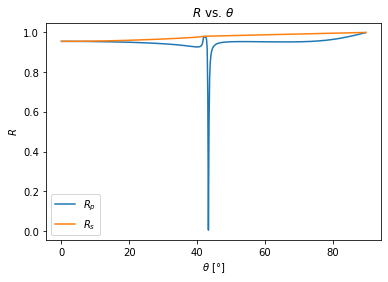

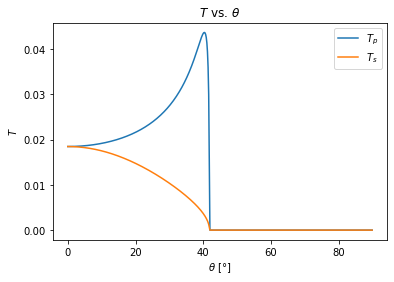

In [8]:
# calculation
n = np.array([1.5, 0.08+4.24j, 1.])
h = np.array([50.])
theta0 = np.linspace(0., np.pi/2, 500, endpoint=False)
lamb = 650.

R, T = multilayer_RT(theta0, lamb, n, h)

# plotting
plot_RT_data(theta0, lamb, R, T)

##### *Plotting $R_p$ as a function of $\lambda$:*

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'$R$ vs. $\\lambda$'}, xlabel='$\\lambda$ [nm]', ylabel='$R$'>)

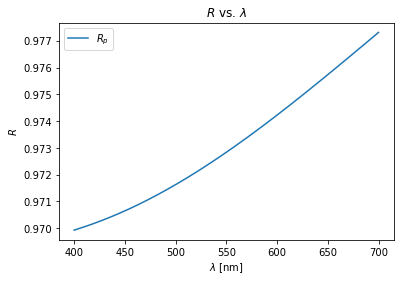

In [9]:
# calculation
n = np.array([1.5, 0.08+4.24j, 1.])
h = np.array([50.])
theta0 = 42*np.pi/180
lamb = np.linspace(400., 700., 500)

R, T = multilayer_RT(theta0, lamb, n, h)

# plotting
plot_RT_data(theta0, lamb, R, T, plot='Rp', lamb_unit='nm') 

##### *Plotting $F(z)$*:

/home/jovyan/COMS-REU/multilayer.py:246: RuntimeWarning: invalid value encountered in true_divide
  Fx = np.abs(Ex)**2 / np.abs(E0plus_p)**2
/home/jovyan/COMS-REU/multilayer.py:248: RuntimeWarning: invalid value encountered in true_divide
  Fz = np.abs(Ez)**2 / np.abs(E0plus_p)**2


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'$F(z)$'}, xlabel='$z$', ylabel='$F(z)$'>)

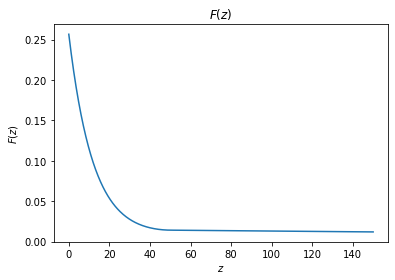

In [10]:
# calculation
n = np.array([1.5, 0.08+4.24j, 1.])
h = np.array([50.])
theta0 = 42*np.pi/180
lamb = 650.
z = np.linspace(0., 150., 500)
E0plus = np.array([0., 1.])

F = multilayer_F(z, theta0, lamb, E0plus, n, h)

# plotting
plot_F_data(z, F)

##### *3D plots of $R_p$ and $T_p$:*

[(<Figure size 432x288 with 1 Axes>,
  <Axes3DSubplot:title={'center':'$R_p$'}, xlabel='$\\theta$ [$\\degree$]', ylabel='$\\lambda$ [nm]'>),
 (<Figure size 432x288 with 1 Axes>,
  <Axes3DSubplot:title={'center':'$T_p$'}, xlabel='$\\theta$ [$\\degree$]', ylabel='$\\lambda$ [nm]'>)]

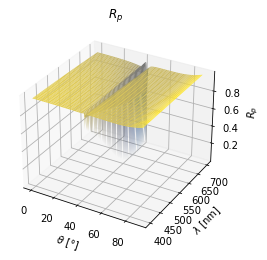

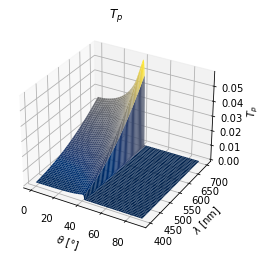

In [11]:
# calculation
n = np.array([1.5, 0.08+4.24j, 1.])
h = np.array([50.])
theta0 = np.linspace(0., np.pi/2, 500, endpoint=False)
lamb = np.linspace(400., 700., 500)

R, T = multilayer_RT(theta0, lamb, n, h)

# plotting
plot_RT_data(theta0, lamb, R, T, plot='Rp Tp', lamb_unit='nm') 

### Identifying modes from reflectivity data

Use the `find_modes(theta0, lamb, R)` function to find the angles and/or wavelengths where surface modes arise in reflectivity data. `theta0` and `lamb` should be the same variables that get passed to `multilayer_RT`, and `R` should be the reflectivity data in precisely the format that it returns.

Exactly one of `theta0` and `lamb` must be a list, and the other must be a scalar. Whichever is a list, it must represent *a continuous range of values*, meaning it must (a) be sorted and (b) have sufficient "resolution" between the two endpoints of the range. (So `numpy.linspace` is a natural choice for generating the input list.)

`find_modes` returns two lists containing `R_Data` [named tuples](https://docs.python.org/3/library/collections.html#collections.namedtuple) (for more info on named tuples see the section on `Bilayer_Recipes`). The first list's tuples describe where modes are for the p-polarized component, and the second list for s-polarized. The `R_Data` tuples themselves contain the angle and wavelength of a mode and the reflectivity value at that mode.

Here is an example where `theta0` gets passed as a list:

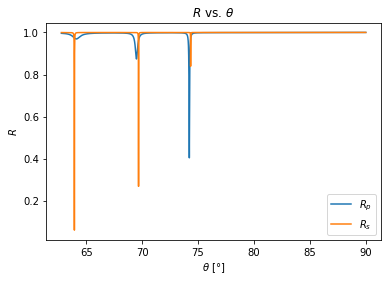

In [12]:
# defining the multilayer properties
n = np.array([2.3+1.5e-4j if i%2==1 else 1.457+3.4e-5j for i in range(8)])
n[0], n[-1] = 1.5, 1.334
h = np.array([121. if i%2==0 else 188. for i in range(6)])
h[-1] = 1500.

# defining the wave properties
theta0_TIR = np.arcsin(n[-1]/n[0]).real
theta0 = np.linspace(theta0_TIR, np.pi/2, 10000, endpoint=False)
lamb = 650

# calculate reflectivity and transmissivity
R, T = multilayer_RT(theta0, lamb, n, h)

# plot reflectivity
fig, ax = plot_RT_data(theta0, lamb, R, T, plot='Rp Rs')

In [13]:
print("now find the modes!")
p_modes, s_modes = find_modes(theta0, lamb, R)
print("p_modes =", p_modes)
print("s_modes =", s_modes)
print()

print("angles in degrees:")
print("p_modes angles =", [mode.theta0*180/np.pi for mode in p_modes])
print("s_modes angles =", [mode.theta0*180/np.pi for mode in s_modes]) 

now find the modes!
p_modes = [R_Data(theta0=1.2954428175519062, lamb=650, R=0.40385875105911895)]
s_modes = [R_Data(theta0=1.1161163513736494, lamb=650, R=0.06029215128152002), R_Data(theta0=1.216227630691384, lamb=650, R=0.26833673911291334)]

angles in degrees:
p_modes angles = [74.22340604626015]
s_modes angles = [63.94875637925053, 69.68471016581205]


When `theta0` is being passed as a list, for the best results, the range should start at an angle no less than the critical angle for total internal reflection. If not though, the function should still work alright.

`find_modes` has two optional arguments, `R_threshold` and `width_threshold`. Changing these parameters will make the function more or less inclusive in what gets recorded from the data as a mode.

The way `find_modes` works is to first identify all regions in the reflectivity data that are below `R_threshold`, which is by default 0.75. It then checks how "wide" each region is, "width" referring to the range of angles (or wavelengths, depending on which of `theta0` or `lamb` was passed as a list) the region occupies. If the width is less than `width_threshold`—by default 5% of the total width of range being surveyed—then the region is considered a mode and its location is recorded. Otherwise, the region is tossed out.

The units of `width_threshold` should match those of whatever is being passed as the independent variable. So if `theta0` is a list, `width_threshold` should be in radians, and if `lamb` is a list, then it should be in, say, nanometers.

## IV. Features for bilayers with a final defect layer

### `Bilayer_Recipe` objects

A commmon multilayer design for biosensing applications consists of a number of bilayers with a single defect layer at the very bottom. The `Bilayer_Recipe` class describes such a bilayer's design. Specifically, it is a **[named tuple](https://docs.python.org/3/library/collections.html#collections.namedtuple)** with eight attributes stored in this order:
1. `n1` - refractive index of first (topmost) medium in bilayer
2. `n2` - refractive index of second medium in bilayer
3. `n_top` - refractive index of first semi-infinite layer
4. `n_bot` - refractive index of last semi-infinite layer
5. `h1` - depth of first medium in bilayer
6. `h2` - depth of second medium in bilayer
7. `h_defect` - depth of the final (bottommost) defect layer
8. `num_bilayers` - number of bilayers

So for example, to create a `Bilayer_Recipe` object describing the biosensing multilayer in Robertson et. al., Elsevier, 2020:

In [14]:
biosensor_recipe = Bilayer_Recipe(
    2.3+1.5e-4j,    # n1 (TiO2)
    1.457+3.4e-5j,  # n2 (SiO2)
    1.5,            # n_top (glass slide)
    1.334,          # n_bot (water)
    121.,           # h1 (TiO2)
    188.,           # h2 (SiO2)
    410.,           # h_defect
    3               # num_bilayers
)
print(biosensor_recipe)

Bilayer_Recipe(n1=(2.3+0.00015j), n2=(1.457+3.4e-05j), n_top=1.5, n_bot=1.334, h1=121.0, h2=188.0, h_defect=410.0, num_bilayers=3)


You can access each of the eight attributes by using the dot operator, or by indexing into it like any other tuple:

In [15]:
print("biosensor_recipe.n1 =", biosensor_recipe.n1)
print("biosensor_recipe[0] =", biosensor_recipe[0])
print()
print("biosensor_recipe.h_defect =", biosensor_recipe.h_defect)
print("biosensor_recipe[6] =", biosensor_recipe[6])
print()
print("etc.")

biosensor_recipe.n1 = (2.3+0.00015j)
biosensor_recipe[0] = (2.3+0.00015j)

biosensor_recipe.h_defect = 410.0
biosensor_recipe[6] = 410.0

etc.


Use the `recipe_to_nh(recipe)` function to quickly convert a `Bilayer_Recipe` into the `n` and `h` lists needed for the `multilayer_RT`/`multilayer_F` functions:

In [16]:
n, h = recipe_to_nh(biosensor_recipe)
print("n =", n)
print("h =", h)

n = [1.5  +0.0e+00j 2.3  +1.5e-04j 1.457+3.4e-05j 2.3  +1.5e-04j
 1.457+3.4e-05j 2.3  +1.5e-04j 1.457+3.4e-05j 1.334+0.0e+00j]
h = [121. 188. 121. 188. 121. 410.]


The last note here is that `Bilayer_Recipe`s really are just fancy tuples--meaning, anywhere in the library code where you might use a `Bilayer_Recipe`, you can just as well use a tuple with eight entries. They are nice though for organization purposes.

### Cataloguing all modes from a set of bilayer recipes

Use the `find_recipe_modes(theta0, lamb, all_recipes)` function to catalog the locations of surface modes from a set of bilayer recipes.

`all_recipes` is some finite iterable with all the `Bilayer_Recipe`s among which you want to catalog the modes. For example, it can be a list of recipes, or a generator of recipes.

The function will return a dictionary. The keys are `Bilayer_Recipe`s, and the values are the output of calling `find_modes` on the multilayer described by that recipe. Thus (as is required by `find_modes`) exactly one of `theta0` and `lamb` must be a list and the other a scalar.

In [17]:
n_TiO2, n_SiO2 = 2.3+1.5e-4j, 1.457+3.4e-5j
n_glass, n_water = 1.5, 1.334

# defining wave properties
theta0_TIR = np.arcsin(n_water/n_glass)
theta0 = np.linspace(theta0_TIR, np.pi/2, 1000, endpoint=False)
lamb = 650.

# defining a set of recipes
all_recipes = []
for h_TiO2 in np.linspace(121., 171., num=10):
    for h_SiO2 in np.linspace(188., 238., num=10):
        h_defect_lo = 1.2*max(h_TiO2, h_SiO2)
        h_defect_hi = h_defect_lo + 50.
        for h_defect in np.linspace(h_defect_lo, h_defect_hi, num=10):
            for num_bilayers in range(3, 7):
                all_recipes.append(Bilayer_Recipe(
                    n1=n_TiO2, n2=n_SiO2, n_top=n_glass, n_bot=n_water,
                    h1=h_TiO2, h2=h_SiO2, h_defect=h_defect,
                    num_bilayers=num_bilayers)
                )

# catalog all modes!
modes = find_recipe_modes(theta0, lamb, all_recipes)

print("let's look at one of the entries in the dictionary:")

Looping over all recipes...
    On recipe 1 / 4000, 0% done
    On recipe 401 / 4000, 10% done
    On recipe 801 / 4000, 20% done
    On recipe 1201 / 4000, 30% done
    On recipe 1601 / 4000, 40% done
    On recipe 2001 / 4000, 50% done
    On recipe 2401 / 4000, 60% done
    On recipe 2801 / 4000, 70% done
    On recipe 3201 / 4000, 80% done
    On recipe 3601 / 4000, 90% done
... Done.
